# Fashion MNIST 활용해 AutoEncoder 설계하기

<font color = "#CC3D3D"><p>
- [1.모듈 import](#1.모듈-import)
- [2.장비 확인하기](#2.장비-확인하기)
- [3.FashionMNIST data 다운하기](#3.FashionMNIST-data-다운하기)
- [4.데이터 확인하기](#4.데이터-확인하기)
- [5.데이터 이미지 확인하기](#5.데이터-이미지-확인하기)    
- [6.AutoEncoder 모델 설계하기](#6.AutoEncoder-모델-설계하기)      
- [7.Optimizer, Loss Function](#7.Optimizer,-Loss-Function)
- [8.AE 모델 Training 함수 정의](#8.AE-모델-Training-함수-정의)
- [9.AE 모델 Evaluation 함수 정의](#9.AE-모델-Evaluation-함수-정의)
- [10.Test set 결과 확인](#10.Test-set-결과-확인)
- [※참고: Auto Encoder에 convolution 적용하기](#※참고:-Auto-Encoder에-convolution-적용하기)

## 1.모듈 import

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

## 2.장비 확인하기

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using Pytorch Version: {}, Device: {}'.format(torch.__version__, DEVICE))

Using Pytorch Version: 1.7.1+cu110, Device: cuda


### Hyper parameter

In [3]:
BATCH_SIZE = 32
EPOCHS = 10

## 3.FashionMNIST data 다운하기

In [4]:
# 데이터셋 다운로드
train_dataset = datasets.FashionMNIST(root = "./FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "./FashionMNIST",
                                      train = False,
                                      transform = transforms.ToTensor())

# 데이터셋 배치단위로 분할 저장 
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

## 4.데이터 확인하기

In [5]:
for(X_train, y_train) in train_loader:
    print(f"X_train: {X_train.size()}, type: {X_train.type()}")
    print(f"y_train: {y_train.size()}, type: {y_train.type()}")
    break
    
print('\n')
print(train_dataset)
print('\n')
print(test_dataset)

print('\n')
print(f"number of classes: {len(train_dataset.classes)}")

X_train: torch.Size([32, 1, 28, 28]), type: torch.FloatTensor
y_train: torch.Size([32]), type: torch.LongTensor


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./FashionMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()


Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./FashionMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


number of classes: 10


## 5.데이터 이미지 확인하기

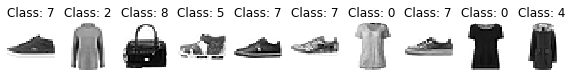

In [6]:
plt_size = 1
plt.figure(figsize = (10 * plt_size, plt_size))
for i in range(10):                              
    plt.subplot(1, 10, i + 1)                  # class가 10개 이므로 10개의 공간 필요
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title(f'Class: {str(y_train[i].item())}')

## 6.AutoEncoder 모델 설계하기

In [7]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Linear(1 * 28 * 28, 512),
                        nn.ReLU(),
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Linear(256, 32)
        )
        
        self.decoder = nn.Sequential(
                        nn.Linear(32, 256),
                        nn.ReLU(),
                        nn.Linear(256, 512),
                        nn.ReLU(),
                        nn.Linear(512, 1 * 28 * 28)
        )   # 마지막 node에 activation function을 적용할 필요는 없습니다.
        
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## 7.Optimizer, Loss Function

In [8]:
model = AE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


## 8.AE 모델 Training 함수 정의

In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()               
    
    for batch_idx, (image, _) in enumerate(train_loader):        # 입력 data 이미지 자체가 타깃이기 떄문에 label data는 생략한다.
        image = image.view(-1, 28 * 28).to(DEVICE)             # 1 batch 당-> 32 * (28 * 28) 
        target = image.view(-1, 28 * 28).to(DEVICE)            # 입력과 타겟 값이 똑같다.
        optimizer.zero_grad()
        
        encoded, decoded = model(image)             # model에 image를 넣어 encoded 값과 decoded값을 구한다.
        loss = criterion(decoded, target)          # 계산된 output과 target값의 loss를 산출
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)] \tTrain Loss: {:.6f}".format(
                    Epoch, 
                    batch_idx * len(image), 
                    len(train_loader.dataset), 
                    100. * batch_idx / len(train_loader),
                    loss.item()))

## 9.AE 모델 Evaluation 함수 정의

In [10]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []                       # 나중에 시각화를 위해 실제 이미지들을 저장하기 위한 list
    gen_image = []                        # 나중에 시각화를 위해 생성된 이미지들을 저장하기 위한 list
    
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, target).item() 
            real_image.append(image.to("cpu"))     # 나중에 이미지 시각화를 위해 사용하기 때문에 Cuda에 
            gen_image.append(decoded.to("cpu"))   # 보내는 것이 아니라 cpu에서 처리한다.
            
    test_loss /= len(test_loader.dataset)  # 현재까지 계산된 test_loss 값을 mini_batch 갯수만큼 나눠 평균 산출
    return test_loss, real_image, gen_image

## 10.Test set 결과 확인

Train Epoch: 1 [0/60000(0%)] 	Train Loss: 0.216228
Train Epoch: 1 [6400/60000(11%)] 	Train Loss: 0.023767
Train Epoch: 1 [12800/60000(21%)] 	Train Loss: 0.025794
Train Epoch: 1 [19200/60000(32%)] 	Train Loss: 0.019440
Train Epoch: 1 [25600/60000(43%)] 	Train Loss: 0.018950
Train Epoch: 1 [32000/60000(53%)] 	Train Loss: 0.018088
Train Epoch: 1 [38400/60000(64%)] 	Train Loss: 0.018683
Train Epoch: 1 [44800/60000(75%)] 	Train Loss: 0.014235
Train Epoch: 1 [51200/60000(85%)] 	Train Loss: 0.014578
Train Epoch: 1 [57600/60000(96%)] 	Train Loss: 0.015765

[EPOCH: 1], 	Test Loss: 0.0005 


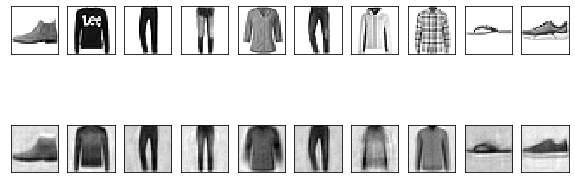

Train Epoch: 2 [0/60000(0%)] 	Train Loss: 0.015532
Train Epoch: 2 [6400/60000(11%)] 	Train Loss: 0.016084
Train Epoch: 2 [12800/60000(21%)] 	Train Loss: 0.013775
Train Epoch: 2 [19200/60000(32%)] 	Train Loss: 0.014754
Train Epoch: 2 [25600/60000(43%)] 	Train Loss: 0.015472
Train Epoch: 2 [32000/60000(53%)] 	Train Loss: 0.014103
Train Epoch: 2 [38400/60000(64%)] 	Train Loss: 0.013185
Train Epoch: 2 [44800/60000(75%)] 	Train Loss: 0.013419
Train Epoch: 2 [51200/60000(85%)] 	Train Loss: 0.012126
Train Epoch: 2 [57600/60000(96%)] 	Train Loss: 0.011100

[EPOCH: 2], 	Test Loss: 0.0004 


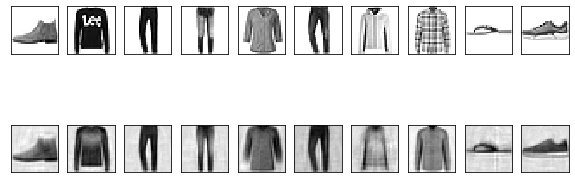

Train Epoch: 3 [0/60000(0%)] 	Train Loss: 0.011438
Train Epoch: 3 [6400/60000(11%)] 	Train Loss: 0.012036
Train Epoch: 3 [12800/60000(21%)] 	Train Loss: 0.011074
Train Epoch: 3 [19200/60000(32%)] 	Train Loss: 0.011575
Train Epoch: 3 [25600/60000(43%)] 	Train Loss: 0.012521
Train Epoch: 3 [32000/60000(53%)] 	Train Loss: 0.013276
Train Epoch: 3 [38400/60000(64%)] 	Train Loss: 0.008403
Train Epoch: 3 [44800/60000(75%)] 	Train Loss: 0.012668
Train Epoch: 3 [51200/60000(85%)] 	Train Loss: 0.011304
Train Epoch: 3 [57600/60000(96%)] 	Train Loss: 0.011180

[EPOCH: 3], 	Test Loss: 0.0004 


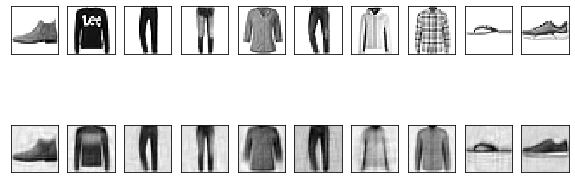

Train Epoch: 4 [0/60000(0%)] 	Train Loss: 0.011925
Train Epoch: 4 [6400/60000(11%)] 	Train Loss: 0.010896
Train Epoch: 4 [12800/60000(21%)] 	Train Loss: 0.011885
Train Epoch: 4 [19200/60000(32%)] 	Train Loss: 0.012016
Train Epoch: 4 [25600/60000(43%)] 	Train Loss: 0.011276
Train Epoch: 4 [32000/60000(53%)] 	Train Loss: 0.011071
Train Epoch: 4 [38400/60000(64%)] 	Train Loss: 0.010298
Train Epoch: 4 [44800/60000(75%)] 	Train Loss: 0.011085
Train Epoch: 4 [51200/60000(85%)] 	Train Loss: 0.010706
Train Epoch: 4 [57600/60000(96%)] 	Train Loss: 0.011644

[EPOCH: 4], 	Test Loss: 0.0004 


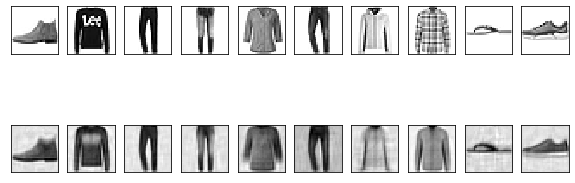

Train Epoch: 5 [0/60000(0%)] 	Train Loss: 0.011854
Train Epoch: 5 [6400/60000(11%)] 	Train Loss: 0.009911
Train Epoch: 5 [12800/60000(21%)] 	Train Loss: 0.012553
Train Epoch: 5 [19200/60000(32%)] 	Train Loss: 0.011444
Train Epoch: 5 [25600/60000(43%)] 	Train Loss: 0.011954
Train Epoch: 5 [32000/60000(53%)] 	Train Loss: 0.009608
Train Epoch: 5 [38400/60000(64%)] 	Train Loss: 0.009340
Train Epoch: 5 [44800/60000(75%)] 	Train Loss: 0.009913
Train Epoch: 5 [51200/60000(85%)] 	Train Loss: 0.009391
Train Epoch: 5 [57600/60000(96%)] 	Train Loss: 0.009850

[EPOCH: 5], 	Test Loss: 0.0003 


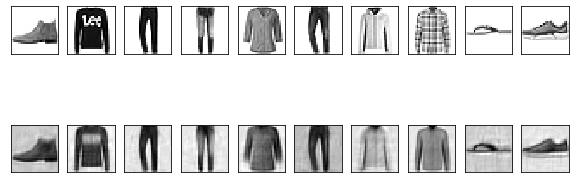

Train Epoch: 6 [0/60000(0%)] 	Train Loss: 0.009034
Train Epoch: 6 [6400/60000(11%)] 	Train Loss: 0.008766
Train Epoch: 6 [12800/60000(21%)] 	Train Loss: 0.009822
Train Epoch: 6 [19200/60000(32%)] 	Train Loss: 0.009182
Train Epoch: 6 [25600/60000(43%)] 	Train Loss: 0.010669
Train Epoch: 6 [32000/60000(53%)] 	Train Loss: 0.012025
Train Epoch: 6 [38400/60000(64%)] 	Train Loss: 0.012435
Train Epoch: 6 [44800/60000(75%)] 	Train Loss: 0.008195
Train Epoch: 6 [51200/60000(85%)] 	Train Loss: 0.009335
Train Epoch: 6 [57600/60000(96%)] 	Train Loss: 0.010901

[EPOCH: 6], 	Test Loss: 0.0003 


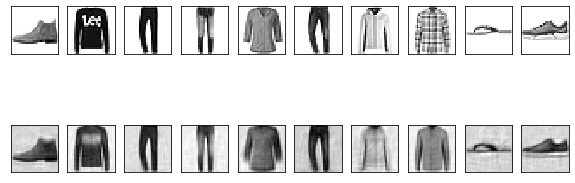

Train Epoch: 7 [0/60000(0%)] 	Train Loss: 0.008684
Train Epoch: 7 [6400/60000(11%)] 	Train Loss: 0.010833
Train Epoch: 7 [12800/60000(21%)] 	Train Loss: 0.009095
Train Epoch: 7 [19200/60000(32%)] 	Train Loss: 0.008739
Train Epoch: 7 [25600/60000(43%)] 	Train Loss: 0.010164
Train Epoch: 7 [32000/60000(53%)] 	Train Loss: 0.011036
Train Epoch: 7 [38400/60000(64%)] 	Train Loss: 0.010038
Train Epoch: 7 [44800/60000(75%)] 	Train Loss: 0.010004
Train Epoch: 7 [51200/60000(85%)] 	Train Loss: 0.013149
Train Epoch: 7 [57600/60000(96%)] 	Train Loss: 0.011428

[EPOCH: 7], 	Test Loss: 0.0003 


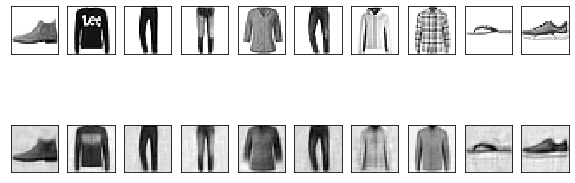

Train Epoch: 8 [0/60000(0%)] 	Train Loss: 0.012584
Train Epoch: 8 [6400/60000(11%)] 	Train Loss: 0.008719
Train Epoch: 8 [12800/60000(21%)] 	Train Loss: 0.008276
Train Epoch: 8 [19200/60000(32%)] 	Train Loss: 0.009586
Train Epoch: 8 [25600/60000(43%)] 	Train Loss: 0.010500
Train Epoch: 8 [32000/60000(53%)] 	Train Loss: 0.010699
Train Epoch: 8 [38400/60000(64%)] 	Train Loss: 0.009152
Train Epoch: 8 [44800/60000(75%)] 	Train Loss: 0.010271
Train Epoch: 8 [51200/60000(85%)] 	Train Loss: 0.011375
Train Epoch: 8 [57600/60000(96%)] 	Train Loss: 0.010143

[EPOCH: 8], 	Test Loss: 0.0003 


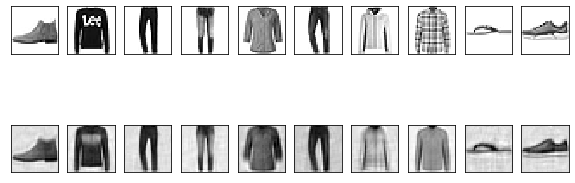

Train Epoch: 9 [0/60000(0%)] 	Train Loss: 0.008933
Train Epoch: 9 [6400/60000(11%)] 	Train Loss: 0.012251
Train Epoch: 9 [12800/60000(21%)] 	Train Loss: 0.009811
Train Epoch: 9 [19200/60000(32%)] 	Train Loss: 0.009946
Train Epoch: 9 [25600/60000(43%)] 	Train Loss: 0.009166
Train Epoch: 9 [32000/60000(53%)] 	Train Loss: 0.012332
Train Epoch: 9 [38400/60000(64%)] 	Train Loss: 0.008208
Train Epoch: 9 [44800/60000(75%)] 	Train Loss: 0.007867
Train Epoch: 9 [51200/60000(85%)] 	Train Loss: 0.010452
Train Epoch: 9 [57600/60000(96%)] 	Train Loss: 0.010241

[EPOCH: 9], 	Test Loss: 0.0003 


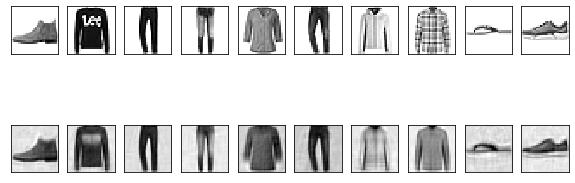

Train Epoch: 10 [0/60000(0%)] 	Train Loss: 0.011132
Train Epoch: 10 [6400/60000(11%)] 	Train Loss: 0.007941
Train Epoch: 10 [12800/60000(21%)] 	Train Loss: 0.008435
Train Epoch: 10 [19200/60000(32%)] 	Train Loss: 0.009302
Train Epoch: 10 [25600/60000(43%)] 	Train Loss: 0.010480
Train Epoch: 10 [32000/60000(53%)] 	Train Loss: 0.008571
Train Epoch: 10 [38400/60000(64%)] 	Train Loss: 0.007345
Train Epoch: 10 [44800/60000(75%)] 	Train Loss: 0.010837
Train Epoch: 10 [51200/60000(85%)] 	Train Loss: 0.010281
Train Epoch: 10 [57600/60000(96%)] 	Train Loss: 0.009447

[EPOCH: 10], 	Test Loss: 0.0003 


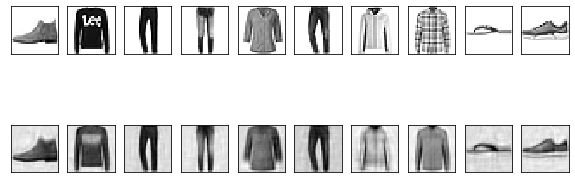

In [11]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f} ".format(Epoch, test_loss))
    
    f, a = plt.subplots(2, 10, figsize = (10, 4))  # 결과물을 산출하기 위한 10, 4짜리 subplots 10개를 준비
    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28)) # 앞서 Vector로 표현한 (28 * 28)size image를 list에 담아 
                                                     # 놓았기 때문에 [0]로 먼저 벗겨주고 i번 째 image를
                                                     # 다시 2차원으로 바꾼다.
        a[0][i].imshow(img, cmap = "gray_r")        # sub plot 0번째 행에 showing
        a[0][i].set_xticks(())                      # x축을 안보이게
        a[0][i].set_yticks(())                      # y축을 안보이게
    for i in range(10):
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")        # sub plot 1번째 행에 showing
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

# ※참고: Auto Encoder에 convolution 적용하기

### Encoder와 Decoder 설정 부분만 다룰 것

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 16, 3, padding = 1)      # batch x 16 x 28 x 28             
                        nn.ReLU(),
                        nn.BatchNorm2d(16),                   # 2차원 data에 대한 적용이므로 2d사용
                        nn.Conv2d(16, 32, 3, padding = 1)      # batch x 32 x 28 x 28             
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 64, 3, padding = 1)      # batch x 64 x 28 x 28             
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2, 2)                    # batch x 64 x 14 x 14 pooling으로 size 감소 
        )
        
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, padding = 1)      # batch x 128 x 14 x 14             
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxUnpool2d(2,2),
                        nn.Conv2d(128, 256, 3, padding = 1)      # batch x 256 x 7 x 7             
                        nn.ReLU(),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels = 256,     # batch x 128 x 14 x 14
                                           out_channels = 128,
                                           kernel_size = 3,
                                           stride = 2,
                                           padding = 1,
                                           out_padding = 1)                   
                        nn.ReLU(),
                        nn.BatchNorm2d(128),                  
                        nn.ConvTranspose2d(128, 64, 3, 1, 1)       # batch x 64 x 14 x 14             
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
            
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64, 16, 3, 1, 1)       # batch x 16 x 14 x 14           
                        nn.ReLU(),
                        nn.BatchNorm2d(16),                   
                        nn.ConvTranspose2d(16, 1, 3, 2, 1, 1)       # batch x 1 x 28 x 28             
                        nn.ReLU(),
                       
         )
    def forward(self, x):
        out = x.view(batch_size, 256, 7, 7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out       
            